<a href="https://colab.research.google.com/github/Will-Gilmour/Will-Gilmour/blob/main/MTK_ComboRNN_v6_DataIn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MRgFUS combination model - Convolution with Recurrence
Need to be careful with the data set-up, each patient should have data pre-processed and then fed into the network using the code below, with the corresponding clinical score.

In [ ]:
# If any missing packages from the next section, need to uncomment specific parts of this to get them installed
!pip install torch
!pip install sklearn
!pip install numpy
!pip install torchinfo
!pip install SimpleITK
!pip install sys
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.7 MB/s eta 0:00:00
  error: subprocess-

In [ ]:
# for learning and data preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np #number crunching

# for getting summary info on models
from torchinfo  import summary

# for nifti management
import SimpleITK as sitk

# for data visualization
import sys
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Using device:', device)

Using device: cuda


# Data Import + organise

In [ ]:
# ## Important note here - when scans are missing for a patient, include None as part of the 5 for inclusion, then np.nan for the score
# # Python may have more issues dealing with the space in the path name, if this is not loading any of the scans, would recommend changing the folder name to Warped_Scans (may have already done this, if so, just need to change in here)

# #Data importing - make sure file names all line up correctly!
# patient_data = [
#                 { # Patient 1
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/iP1_D1.nii',          # Day 1
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/iP1_M1.nii',          # 1 Month
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/iP1_M3.nii',          # 3 Months
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/iP1_M6.nii',          # 6 Months
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/iP1_M12.nii'          # 12 Months
#                        ],
#         'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores
#                   },

#                 #-----------------------#

#                 { # Patient 2
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/iP2_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/iP2_M1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/iP2_M3.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/iP2_M6.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/iP2_M12.nii'
#                        ],
#         'scores': np.array([
#             1,
#     0.916666666666667,
#     0.916666666666667,
#     0.916666666666667,
#     0.916666666666667])  # Corresponding scores
#                   },
#                                 #-----------------------#

#                 { # Patient 3
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P3_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P3_M1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P3_M3.nii',
#     None,
#     None
#                        ],
#         'scores': np.array([0.818181818181818,
#     0.409090909090909,
#     0.454545454545455, np.nan, np.nan])  # Corresponding scores, with missing value
#                   },
#                 #-----------------------#
#                 { # Patient 4
#         'file_paths': [
#             '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P4_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P4_M1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P4_M3.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P4_M6.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P4_M12.nii'
#     ],
#         'scores': np.array([0.478260869565217,
#     0.304347826086957,
#     0.217391304347826,
#     0.173913043478261,
#     0.217391304347826])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 5
#         'file_paths': [
#             '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P5_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P5_M1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P5_M3.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P5_M6.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P5_M12.nii'
#     ],
#         'scores': np.array([0.652173913043478,
#     0.434782608695652,
#     0.347826086956522,
#     0.173913043478261,
#     0.26])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 6
#         'file_paths': ['/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P6_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P6_M1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P6_M3.nii',
#       None,
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P6_M12.nii'
#                        ],
#         'scores': np.array([0.782608695652174,
#     0.434782608695652,
#     0.260869565217391,
#                             np.nan,
#     0.04])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 7
#         'file_paths': [    '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P7_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P7_M1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P7_M3.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P7_M6.nii',
#                        None                                               # 12 Months (missing)
#                        ],
#         'scores': np.array([ 0.739130434782609,
#     0.695652173913043,
#     0.695652173913043,
#     0.7, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 8
#         'file_paths': [    '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P8_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P8_M1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P8_M3.nii',
#                            None                                       ,
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P8_M12.nii'
#                        ],
#         'scores': np.array([0.772727272727273,
#     0.681818181818182,
#     0.636363636363636, np.nan, 0.59])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 9
#         'file_paths': [    '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P9_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P9_M1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P9_M3.nii',
#                            None                                       ,
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P9_M12.nii'
#                        ],
#         'scores': np.array([0.791666666666667,
#     0.5,
#     0.5,
#     np.nan,
#     0.33  ])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 10
#         'file_paths': [
#             '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P10_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P10_M1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P10_M3.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P10_M6.nii' ,
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P10_M12.nii'
#                        ],
#         'scores': np.array([0.681818181818182,
#     0.818181818181818,
#     0.818181818181818,
#     0.954545454545455,
#     0.86])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 11
#                'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P11_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P11_M1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P11_M3.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P11_M6.nii' ,
# None
#     ],
#         'scores': np.array([ 0.863636363636364,
#     0.727272727272727,
#     0.772727272727273,
#     0.73, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 12
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/iP12_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/iP12_M1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/iP12_M3.nii',
# None,
#     None
#                        ],
#         'scores': np.array([0.7,0.7,0.7, np.nan, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 13
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P13_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P13_M1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P13_M3.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P13_M6.nii' ,
# None                       ],
#         'scores': np.array([ 0.833333333333333,
#     0.75,
#     0.583333333333333,
#     0.38, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 14
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P14_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P14_M1.nii',
#     None,
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P14_M6.nii' ,
# None                       ],
#         'scores': np.array([0.8, 0.6,  np.nan, 0.6, np.nan])  # Corresponding scores, with missing value
#                   },
#                                #-----------------------#

#                 { # Patient 15
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P15_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P15_M1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P15_M3.nii',
# None,
#     None
#     ],
#         'scores': np.array([0.75, 0.55, 0.45, np.nan, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 16
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P16_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P16_M1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P16_M3.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P16_M6.nii' ,
# None
#     ],
#         'scores': np.array([0.791666666666667,
#     0.625,
#     0.583333333333333,
#     0.54, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 18
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P18_D1.nii',
# None,
#     None,
#     None,
# None
#     ],
#         'scores': np.array([0.75, np.nan,np.nan, np.nan, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 19
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P19_D1.nii',
#     None,
# '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P19_M3.nii',
#     None,
# None
#     ],
#         'scores': np.array([0.94, np.nan,0.71, np.nan, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 20
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P20_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P20_M1.nii',
#     None,
#     None,
# None
#     ],
#         'scores': np.array([0.77, 0.53,np.nan, np.nan, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 21
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P21_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P21_M1.nii',
#     None,
#     None,
# None
#     ],
#         'scores': np.array([0.57, 0.48,np.nan, np.nan, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 22
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P22_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P22_M1.nii',
#     None,
#     None,
# None
#     ],
#         'scores': np.array([0.9, 0.7,np.nan, np.nan, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 23
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P23_D1.nii',
#     None,
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P20_M3.nii',
#     None,
#     None,
#     ],
#         'scores': np.array([0.78, np.nan,0.39, np.nan, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 24
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/iP24_D1.nii',
#     None,
#     None,
#     None,
#     None
#     ],
#         'scores': np.array([0.42, np.nan,np.nan, np.nan, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 25
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P25_D1.nii',
#     None,
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P25_M3.nii',
#     None,
# None
#     ],
#         'scores': np.array([0.67, np.nan,0.5, np.nan, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 26
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P26_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P26_M1.nii',
#     None,
#     None,
# None
#     ],
#         'scores': np.array([0.67, 0.5,np.nan, np.nan, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 27
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P27_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P27_M1.nii',
#     None,
#     None,
# None
#     ],
#         'scores': np.array([0.96, 0.75,np.nan, np.nan, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 29
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P29_D1.nii',
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P29_M1.nii',
#     None,
#     None,
# None
#     ],
#         'scores': np.array([0.83, 0.78,np.nan, np.nan, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 30
#         'file_paths': [
#     None,
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P30_M1.nii',
#     None,
#     None,
#     None
#     ],
#         'scores': np.array([0.75, np.nan,np.nan, np.nan, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 31
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P31_D1.nii',
#     None,
#     None,
#     None,
# None
#     ],
#         'scores': np.array([0.71, np.nan,np.nan, np.nan, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#

#                 { # Patient 32
#         'file_paths': [
#     '/home/will/Documents/Thalamotomy/Imaging/Warped Scans/P32_D1.nii',
#     None,
#     None,
#     None,
#     None
#     ],
#         'scores': np.array([0.7, np.nan,np.nan, np.nan, np.nan])  # Corresponding scores, with missing value
#                   },
#                                 #-----------------------#
#                 ]

In [ ]:
#Fake testing!
patient_data = [
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([             1,    0.916666666666667,    0.916666666666667,    0.916666666666667,    0.916666666666667])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.478260869565217,
    0.304347826086957,
    0.217391304347826,
    0.173913043478261,
    0.217391304347826])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.818181818181818,
    0.409090909090909,
    0.454545454545455,
                            np.nan,
                            np.nan
                            ])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([    0.652173913043478,
    0.434782608695652,
    0.347826086956522,
    0.173913043478261,
    0.26])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([    0.782608695652174,
    0.434782608695652,
    0.260869565217391,
    0.04,
                                0.04])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([    0.739130434782609,
    0.695652173913043,
    0.695652173913043,
    0.7,
                                0.7])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([    0.772727272727273,
    0.681818181818182,
    0.636363636363636,
    0.59,
                                np.nan])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([    0.791666666666667,
    0.5,
    0.5,
    0.33,
                                np.nan])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.681818181818182,
    0.818181818181818,
    0.818181818181818,
    0.954545454545455,
    0.86])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([    0.863636363636364,
    0.727272727272727,
    0.772727272727273,
    0.73,
                                np.nan])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([    0.7,
    0.7,
    0.7,
                                np.nan,
                                np.nan])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([    0.833333333333333,
    0.75,
    0.583333333333333,
    0.38,
                                np.nan])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([1, 0.9, 0.6, 0.6, 0.55])  # Corresponding scores, with missing value
                  },
                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii'                                               # 12 Months (missing)
                       ],
        'scores': np.array([1, 0.9, 0.6, 0.6, 0.55])  # Corresponding scores, with missing value
                  },

                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       None                                               # 12 Months (missing)
                       ],
        'scores': np.array([1, 0.9, 0.6, 0.6, np.nan])  # Corresponding scores, with missing value
                  },

                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       None                                               # 12 Months (missing)
                       ],
        'scores': np.array([1, 0.9, 0.6, 0.6, np.nan])  # Corresponding scores, with missing value
                  },

                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       None                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,0.565217391304348])  # Corresponding scores, with missing value
                  },

                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       None                                               # 12 Months (missing)
                       ],
        'scores': np.array([1, 0.9, 0.6, 0.6, np.nan])  # Corresponding scores, with missing value
                  },

                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       None                                               # 12 Months (missing)
                       ],
        'scores': np.array([1, 0.9, 0.6, 0.6, np.nan])  # Corresponding scores, with missing value
                  },

                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       None                                               # 12 Months (missing)
                       ],
        'scores': np.array([1, 0.9, 0.6, 0.6, np.nan])  # Corresponding scores, with missing value
                  },

                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       None                                               # 12 Months (missing)
                       ],
        'scores': np.array([1, 0.9, 0.6, 0.6, np.nan])  # Corresponding scores, with missing value
                  },

                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       None                                               # 12 Months (missing)
                       ],
        'scores': np.array([0.826086956521739,0.739130434782609,0.739130434782609,0.739130434782609,
                            np.nan])  # Corresponding scores, with missing value
                  },

                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       None                                               # 12 Months (missing)
                       ],
        'scores': np.array([1, 0.9, 0.6, 0.6, np.nan])  # Corresponding scores, with missing value
                  },

                { # Patient 37
        'file_paths': ['/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # Day 1
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 1 Month
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 3 Months
                       '/content/drive/MyDrive/MTK/RNN/Data/p37_d1.nii',  # 6 Months
                       None                                               # 12 Months (missing)
                       ],
        'scores': np.array([1, 0.9, 0.6, 0.6, np.nan])  # Corresponding scores, with missing value
                  },
                ]

In [ ]:
def load_nii(file_path):
    image = sitk.ReadImage(file_path)
    image_array = sitk.GetArrayFromImage(image)
    return image_array

In [ ]:
# Focusing on important section of data
# test_voi_path = '/home/will/Documents/Thalamotomy/Imaging/Test_VOI.nii'
test_voi_path = '/content/drive/MyDrive/MTK/RNN/Data/Averaged_Masks.nii'
voi = sitk.ReadImage(test_voi_path)
voi_array = sitk.GetArrayFromImage(voi)

In [ ]:
def find_imp_voi(voi_mask):
    # Find the indices where the mask is 1
    ones_indices = np.where(voi_mask == 1)

    # Extract x, y, z coordinates from these indices
    x_coords, y_coords, z_coords = ones_indices

    # Find min and max for each coordinate
    x1, x2 = x_coords.min(), x_coords.max()
    y1, y2 = y_coords.min(), y_coords.max()
    z1, z2 = z_coords.min(), z_coords.max()

    return x1, x2, y1, y2, z1, z2

In [ ]:
x1, x2, y1, y2, z1, z2 = find_imp_voi(voi_array)
y1 -= 2
y2 += 3
print(f'Expected Shape = {x2+1-x1}x{y2+1-y1}x{z2+1-z1}')

Expected Shape = 28x33x28


In [ ]:
# Process data for each patient
for patient in patient_data:
    patient['images'] = []
    for file_path in patient['file_paths']:
        if file_path is not None and os.path.exists(file_path):
            scan = load_nii(file_path)
            voi_scan = scan[x1:x2+1, y1:y2+1, z1:z2+1]
            normalized_voi_scan = voi_scan / np.max(voi_scan)
            patient['images'].append(normalized_voi_scan[np.newaxis, ...])  # Add new axis for batch size
        else:
            patient['images'].append(None)
    patient['scores'] = np.array(patient['scores'])


In [ ]:
class MedicalImageDataset(Dataset):
    def __init__(self, patient_data):
        self.patient_data = patient_data
        self.time_points = torch.Tensor([0, 30, 90, 180, 360])  # Time encoding in days

    def __len__(self):
        return len(self.patient_data)

    def __getitem__(self, idx):
        patient = self.patient_data[idx]

        # Handle missing scans
        image_sequence = []
        for image in patient['images']:
            if image is None:  # Assuming missing scans are represented by None
                # Create a tensor of -1 with the same shape as your scans
                image_sequence.append(torch.full((1, 28, 33, 28), -1))
            else:
                image_sequence.append(torch.Tensor(image))
        image_sequence = torch.stack(image_sequence)

        scores = torch.Tensor(patient['scores'])
        # Mask for missing scores
        mask = ~torch.isnan(scores)
        scores[torch.isnan(scores)] = -1  # Placeholder for missing scores

        return image_sequence, scores, mask, self.time_points



Recommend re-running from here down for different patient selection - will retrain model but not reprocess all the scans to the right place!

ctrl + F10 is the usual command to run after!

In [ ]:
# split data
train_patient_data, test_patient_data = train_test_split(patient_data, test_size=0.1)

#process into dataset object
train_dataset = MedicalImageDataset(train_patient_data)
test_dataset = MedicalImageDataset(test_patient_data)

batchsize = 4
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

# Model arcitechture and set-up

In [ ]:
class CombinedCNNRNN(nn.Module):
    def __init__(self, hidden_dim, num_layers, printtoggle=False):
        super(CombinedCNNRNN, self).__init__()

        # CNN part (Feature Extraction)
        self.conv1 = nn.Conv3d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv3d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv3d(256, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool3d(2, 2)
        self.bn1 = nn.BatchNorm3d(64)
        self.bn2 = nn.BatchNorm3d(128)
        self.bn3 = nn.BatchNorm3d(256)
        cnn_feature_size = 256*3*4*3

        # RNN part
        self.rnn = nn.LSTM(input_size=cnn_feature_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True) #This is the most important layer to think about for the new net, can use any of the following(LSTM, GRU, RNN)
        # LSTM: most complex ~8M parameters to train, potentially has largest representation of early layers for the later predictions
        # GRU: middle complex ~7M parameters, decent represenation of early layers, although not quite the same as LSTM
        # RNN: Simplest ~4M parameters, simple transition between time states, likely to be easiest to train but not as complex of representation
        self.fc = nn.Linear(hidden_dim, 1)

        self.print = printtoggle
        self.hidden_size = hidden_dim
        self.num_layers = num_layers

    def apply_cnn(self, x):
            # Feature extraction
            x = F.relu(self.bn1(self.conv1(x)))
            x = self.pool(F.relu(self.bn1(self.conv2(x))))

            x = F.relu(self.bn2(self.conv3(x)))
            x = self.pool(F.relu(self.bn2(self.conv4(x))))

            x = F.relu(self.bn3(self.conv5(x)))
            x = self.pool(F.relu(self.bn3(self.conv6(x))))

            # Flatten the output for the RNN
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1,int(nUnits))
            print(f'Final CNN output size per time point: {x.shape}') if self.print else None
            return x


    def forward(self, x):
        print(f'Input: {x.shape} \nThis is [batchsize,number of time steps, scan colour channels (grey=1), scan height, scan width, scan depth]') if self.print else None
        batch_size, time_steps, C, H, W, D = x.size()

        # Process each time step through model - hidden state is preserved between time points, meaning there is information availible from the previous scans to be used when processing the current
        outputs = []
        hidden = None # no background for first state
        for t in range(time_steps):
            # Run through CNN
            x_t = self.apply_cnn(x[:, t, :, :, :])  # Process scan at time t

            # Score output

            rnn_out, hidden = self.rnn(x_t.unsqueeze(1),hidden)  # Pass through RNN

            score_t = torch.sigmoid(self.fc(rnn_out.squeeze(1)))  # Predict score at time t
            print(f'Final RNN output size per time point: {score_t.shape}') if self.print else None
            outputs.append(score_t)

        # Stack the outputs for each time step
        yHat = torch.stack(outputs,dim=1)
        print(f'Final RNN output: {yHat.shape}') if self.print else None

        return yHat


In [ ]:
# Test
model = CombinedCNNRNN(hidden_dim=128, num_layers=2,printtoggle=True)
model.to(device)
(image_sequences, scores, masks, times) = next(iter(train_loader))
output = model(image_sequences.to(device))

summary(model, (2,5,1,28,33,28), device=device)

Input: torch.Size([4, 5, 1, 28, 33, 28]) 
This is [batchsize,number of time steps, scan colour channels (grey=1), scan height, scan width, scan depth]
Final CNN output size per time point: torch.Size([4, 9216])
Final RNN output size per time point: torch.Size([4, 1])
Final CNN output size per time point: torch.Size([4, 9216])
Final RNN output size per time point: torch.Size([4, 1])
Final CNN output size per time point: torch.Size([4, 9216])
Final RNN output size per time point: torch.Size([4, 1])
Final CNN output size per time point: torch.Size([4, 9216])
Final RNN output size per time point: torch.Size([4, 1])
Final CNN output size per time point: torch.Size([4, 9216])
Final RNN output size per time point: torch.Size([4, 1])
Final RNN output: torch.Size([4, 5, 1])
Input: torch.Size([2, 5, 1, 28, 33, 28]) 
This is [batchsize,number of time steps, scan colour channels (grey=1), scan height, scan width, scan depth]
Final CNN output size per time point: torch.Size([2, 9216])
Final RNN out

Layer (type:depth-idx)                   Output Shape              Param #
CombinedCNNRNN                           [2, 5, 1]                 --
├─Conv3d: 1-1                            [2, 64, 28, 33, 28]       1,792
├─BatchNorm3d: 1-2                       [2, 64, 28, 33, 28]       128
├─Conv3d: 1-3                            [2, 64, 28, 33, 28]       110,656
├─BatchNorm3d: 1-4                       [2, 64, 28, 33, 28]       (recursive)
├─MaxPool3d: 1-5                         [2, 64, 14, 16, 14]       --
├─Conv3d: 1-6                            [2, 128, 14, 16, 14]      221,312
├─BatchNorm3d: 1-7                       [2, 128, 14, 16, 14]      256
├─Conv3d: 1-8                            [2, 128, 14, 16, 14]      442,496
├─BatchNorm3d: 1-9                       [2, 128, 14, 16, 14]      (recursive)
├─MaxPool3d: 1-10                        [2, 128, 7, 8, 7]         --
├─Conv3d: 1-11                           [2, 256, 7, 8, 7]         884,992
├─BatchNorm3d: 1-12                      [

In [ ]:
# Initialize the model
model = CombinedCNNRNN(hidden_dim=128, num_layers=2)
model = model.to(device)
# Define the loss function and optimizer
lossfun = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed

In [ ]:
# Example training loop
num_epochs = 10  # Number of training epochs
# initialize losses and accuracies
trainLoss = torch.zeros(num_epochs)
testLoss = torch.zeros(num_epochs)

for epochi in range(num_epochs):
    batchLoss = []
    for image_sequences,scores,masks,times in train_loader:
      image_sequences = image_sequences.to(device)
      scores = scores.to(device)
      masks = masks.to(device)
      times = times.to(device)

      # Forward pass
      predictions = model(image_sequences)
      # Masking outputs and scores where no data
      pred_masked = predictions[masks]
      scores_masked = scores[masks].unsqueeze(1)
      # Loss
      loss = lossfun(pred_masked,scores_masked)
      #  loss from this batch
      batchLoss.append(loss.item())

      # BackProp
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
      # Check for NaNs in the loss
      if torch.isnan(loss):
          print("NaN detected in loss, skipping update")
          continue
    # Save loss
    trainLoss[epochi] = np.mean(batchLoss)

    # now for the test
    model.eval()
    image_sequences,scores,masks,times = next(iter(test_loader))
    image_sequences = image_sequences.to(device)
    scores = scores.to(device)
    masks = masks.to(device)
    times = times.to(device)
    # evaluate the model and compute accuracy
    with torch.no_grad():
      # Forward pass
      predictions = model(image_sequences)
      # Masking outputs and scores where no data
      pred_masked = predictions[masks]
      scores_masked = scores[masks].unsqueeze(1)
      # Loss
      loss = lossfun(pred_masked,scores_masked)
    testLoss[epochi] = loss.item();
    model.train()

    msg = f'Epoch [{epochi+1}/{num_epochs}], Current BatchLoss: {trainLoss[epochi]:3f}, Current TestLoss: {testLoss[epochi]:3f}'
    sys.stdout.write('\r' + msg)


Epoch [10/10], Current BatchLoss: 0.020726, Current TestLoss: 0.045450

# Results display

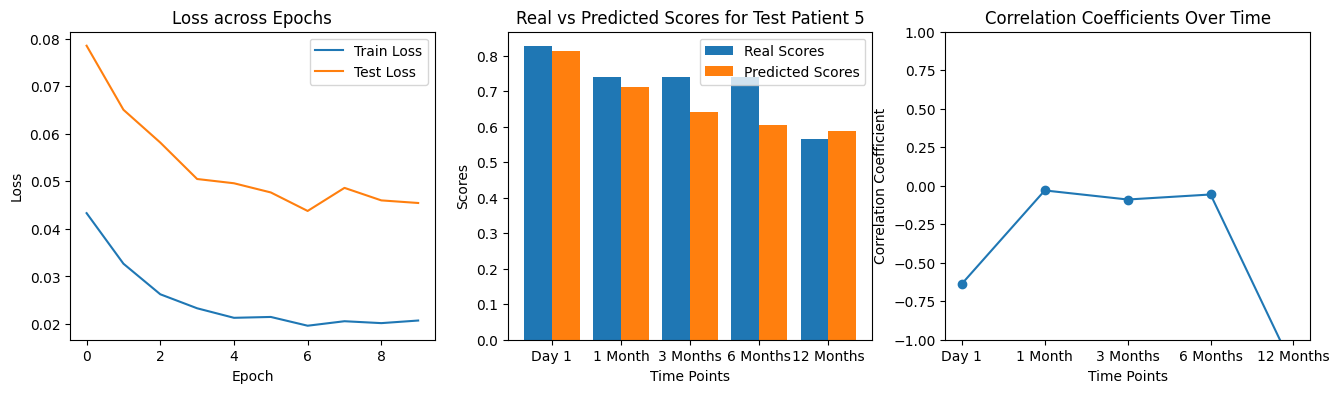

In [ ]:
#setup for display:
model.eval()
real_scores = []
predicted_scores = []

with torch.no_grad():
    for image_sequences, scores, masks, times in test_loader:
        image_sequences = image_sequences.to(device)
        outputs = model(image_sequences).squeeze(-1).to('cpu')  # Get the model's predictions
        predicted_scores.append(outputs.numpy())  # Store predictions
        real_scores.append(scores.numpy())  # Store actual scores
model.train()

# Convert lists to numpy arrays for easier manipulation
real_scores = np.concatenate(real_scores, axis=0)
predicted_scores = np.concatenate(predicted_scores, axis=0)

num_time_points = real_scores.shape[1]
num_participants = real_scores.shape[0]

# Randomly select a patient index
random_index = np.random.randint(0, num_participants)

# Extract scores for the selected patient
selected_real_scores = real_scores[random_index, :]
selected_predicted_scores = predicted_scores[random_index, :]

fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(trainLoss,label='Train Loss')
ax[0].plot(testLoss,label='Test Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_title('Loss across Epochs')


# Plot for a single patient
time_labels = ['Day 1', '1 Month', '3 Months', '6 Months', '12 Months']
ax[1].bar(np.arange(len(time_labels)) - 0.2, selected_real_scores, 0.4, label='Real Scores')
ax[1].bar(np.arange(len(time_labels)) + 0.2, selected_predicted_scores, 0.4, label='Predicted Scores')
ax[1].set_xticks(np.arange(len(time_labels)))
ax[1].set_xticklabels(time_labels)
ax[1].set_title(f"Real vs Predicted Scores for Test Patient {random_index + 1}")
ax[1].set_xlabel("Time Points")
ax[1].set_ylabel("Scores")
ax[1].legend()

from scipy.stats import pearsonr

# Calculate correlation coefficients for each time point
correlation_coeffs = []
for i in range(num_time_points):
    corr = r2_score(real_scores[:, i], predicted_scores[:, i])
    correlation_coeffs.append(corr)

# Plot correlation coefficients
ax[2].plot(time_labels, correlation_coeffs, marker='o')
ax[2].set_title("Correlation Coefficients Over Time")
ax[2].set_xlabel("Time Points")
ax[2].set_ylabel("Correlation Coefficient")
ax[2].set_ylim(-1, 1)  # Correlation coefficients range from -1 to 1

plt.show()



In [ ]:
for i in range(num_time_points):
    print(f'Time point {i+1}')
    print(real_scores[:, i], predicted_scores[:, i])
    print(r2_score(real_scores[:, i], predicted_scores[:, i]))

Time point 1
[1.         1.         0.82608694 0.7826087  0.82608694] [0.8122257 0.8122257 0.8122257 0.8122257 0.8122257]
-0.6367032172459752
Time point 2
[0.9        0.9        0.73913044 0.4347826  0.73913044] [0.7128867 0.7128867 0.7128867 0.7128867 0.7128867]
-0.030604402340371095
Time point 3
[0.6        0.6        0.73913044 0.26086956 0.73913044] [0.64017475 0.64017475 0.64017475 0.64017475 0.64017475]
-0.08956493694062129
Time point 4
[0.6        0.6        0.73913044 0.04       0.73913044] [0.6055461 0.6055461 0.6055461 0.6055461 0.6055461]
-0.056932392052695624
Time point 5
[-1.        -1.         0.5652174  0.04       0.5652174] [0.6070198  0.6070198  0.58901614 0.58901614 0.58901614]
-1.1844917035581424


Original shape: torch.Size([5, 5, 1, 28, 33, 28])
Updated shape after masking: torch.Size([5, 5, 1, 28, 33, 28])


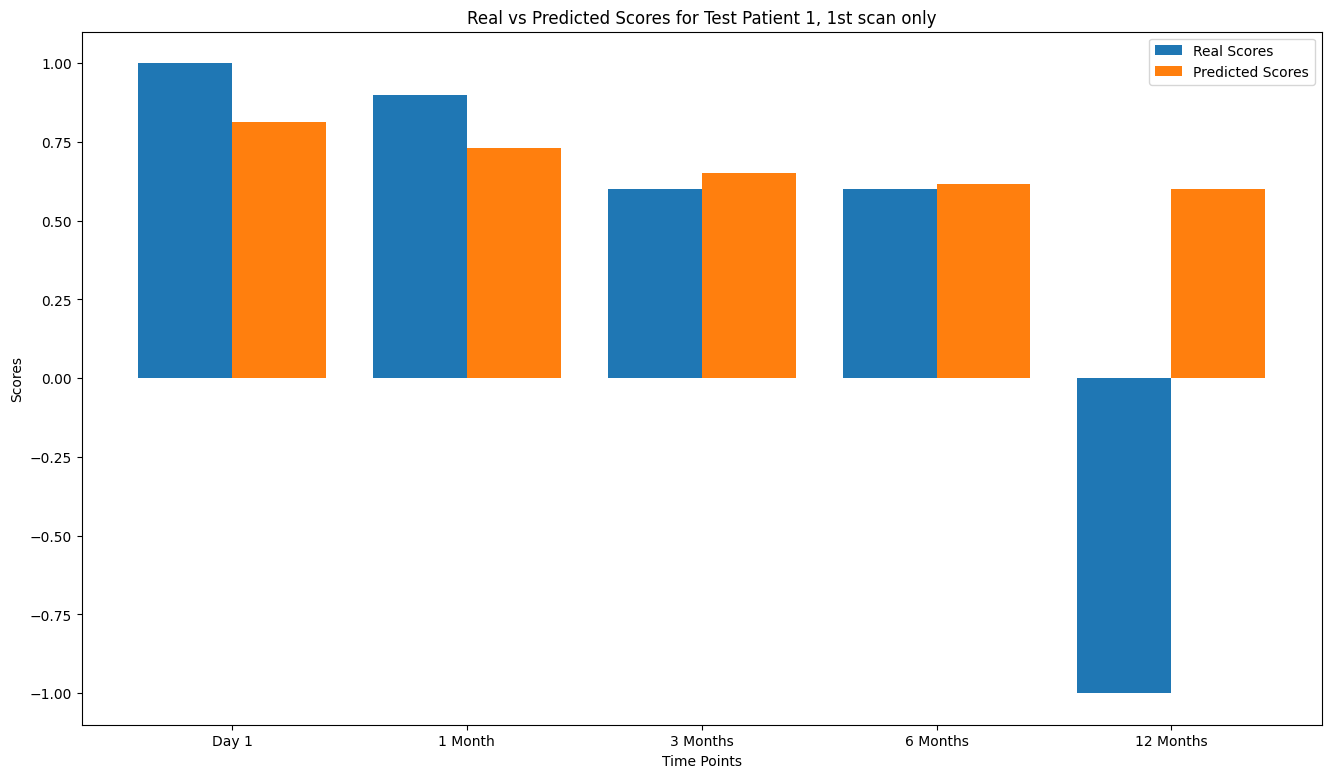

In [ ]:
#setup for second test display:
model.eval()
real_scores_1st = []
predicted_scores_1st = []

with torch.no_grad():
    for image_sequences, scores, masks, times in test_loader:
        # Print original shape for reference
        print("Original shape:", image_sequences.shape)  # Should be [batch size, time points, channels, x, y, z]
        # Initialize a tensor to hold the updated image sequences
        image_sequence_updated = torch.full_like(image_sequences, -1.0)
        # Copy the first time point for each patient in the batch into the updated tensor
        image_sequence_updated[:, 0, :, :, :, :] = image_sequences[:, 0, :, :, :, :].clone().detach()
        # The following print statement is just for debugging purposes to confirm the updated shape
        print("Updated shape after masking:", image_sequence_updated.shape)  # Should remain the same as the original

        image_sequence_updated = image_sequence_updated.to(device)
        outputs = model(image_sequence_updated).squeeze(-1).to('cpu')  # Get the model's predictions
        predicted_scores_1st.append(outputs.numpy())  # Store predictions
        real_scores_1st.append(scores.numpy())  # Store actual scores
model.train()

# Convert lists to numpy arrays for easier manipulation
real_scores_1st = np.concatenate(real_scores_1st, axis=0)
predicted_scores_1st = np.concatenate(predicted_scores_1st, axis=0)

num_time_points = real_scores_1st.shape[1]
num_participants = real_scores_1st.shape[0]

# Randomly select a patient index
random_index = np.random.randint(0, num_participants)
# random_index = 0


# Extract scores for the selected patient
selected_real_scores = real_scores_1st[random_index, :]
selected_predicted_scores = predicted_scores_1st[random_index, :]

fig,ax = plt.subplots(1,1,figsize=(16,9))
# Plot for a single patient
time_labels = ['Day 1', '1 Month', '3 Months', '6 Months', '12 Months']
ax.bar(np.arange(len(time_labels)) - 0.2, selected_real_scores, 0.4, label='Real Scores')
ax.bar(np.arange(len(time_labels)) + 0.2, selected_predicted_scores, 0.4, label='Predicted Scores')
ax.set_xticks(np.arange(len(time_labels)))
ax.set_xticklabels(time_labels)
ax.set_title(f"Real vs Predicted Scores for Test Patient {random_index + 1}, 1st scan only")
ax.set_xlabel("Time Points")
ax.set_ylabel("Scores")
ax.legend()